# torchkeras.KerasModel wandb Demo

You can install torchkeras using pip:
`pip install torchkeras`

Here is a mnist cnn example using torchkeras.KerasModel  with visualization of wandb.


`pip install wandb`


Before you start run this demo, you should first create an account at wandb website  https://wandb.ai/ ,

and get your API keys from the settings page。

You can explore the wandb dashboard created in this demo from the url below:

https://wandb.ai/lyhue1991/mnist_torchkeras


In [1]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lyhue1991. Use `wandb login --relogin` to force relogin


True

In [2]:
import sys 
sys.path.append("..")

In [3]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torchkeras #Attention this line 

### 0, set hyperparameters 

In [4]:
from argparse import Namespace
config = Namespace(
    batch_size = 256,
    lr = 1e-3,
    dropout_p = 0.1,
    )

### 1, prepare data 

In [5]:
import torchvision 
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="mnist/",train=False,download=True,transform=transform)
dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=config.batch_size, shuffle=True, num_workers=2)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=config.batch_size, shuffle=False, num_workers=2)


In [6]:
for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)


torch.Size([256, 1, 28, 28])
torch.Size([256])


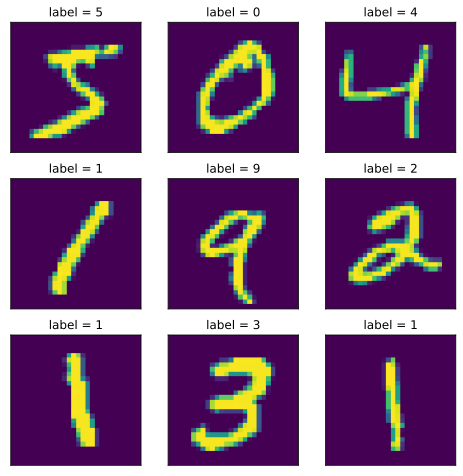

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()


### 2, create the  model

In [8]:
def create_net(config):
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = config.dropout_p))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(64,32))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(32,10))
    return net

net = create_net(config)

class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total
        

In [9]:
model = torchkeras.KerasModel(net,
      loss_fn = nn.CrossEntropyLoss(),
      optimizer= torch.optim.Adam(net.parameters(),lr=0.001),
      metrics_dict = {"acc":Accuracy()},
    )

from torchkeras import summary
summary(model,input_data=features);



--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 32, 26, 26]                  320
MaxPool2d-2                         [-1, 32, 13, 13]                    0
Conv2d-3                              [-1, 64, 9, 9]               51,264
MaxPool2d-4                           [-1, 64, 4, 4]                    0
Dropout2d-5                           [-1, 64, 4, 4]                    0
AdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0
Flatten-7                                   [-1, 64]                    0
Linear-8                                    [-1, 32]                2,080
ReLU-9                                      [-1, 32]                    0
Linear-10                                   [-1, 10]                  330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
-----------------------------------------

### 3, train the model

In [10]:
from torchkeras.kerascallbacks import WandbCallback

wandb_cb = WandbCallback(project='mnist_torchkeras',
                         config=config.__dict__,
                         name=None,
                         save_code=True,
                         save_ckpt=True)
dfhistory=model.fit(train_data=dl_train, 
                    val_data=dl_val, 
                    epochs=15, 
                    patience=5, 
                    monitor="val_acc",
                    mode="max",
                    ckpt_path='checkpoint.pt',
                    callbacks = [wandb_cb]
                   )


<<<<<< 🐌 cpu is used >>>>>>



================================================================================2023-01-30 14:19:23
Epoch 1 / 15

100%|████████████████████████████████| 40/40 [00:01<00:00, 25.08it/s, val_acc=0.954, val_loss=0.161]
<<<<<< reach best val_acc : 0.9537000060081482 >>>>>>

================================================================================2023-01-30 14:19:43
Epoch 2 / 15

100%|████████████████████████████████| 40/40 [00:01<00:00, 25.74it/s, val_acc=0.969, val_loss=0.103]
<<<<<< reach best val_acc : 0.9690999984741211 >>>>>>

================================================================================2023-01-30 14:20:03
Epoch 3 / 15

100%|███████████████████████████████| 40/40 [00:01<00:00, 25.51it/s, val_acc=0.974, val_loss=0.0808]
<<<<<< reach best val_acc : 0.9743000268936157 >>>>>>

================================================================================2023-01-30 14:20:24
Epoch 4 / 15

100%|████████████████████████████████| 40/40 [00:01<00:00, 26.23it/s, val_a

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


    epoch  train_loss  train_acc     lr  val_loss  val_acc
0       1    0.709651   0.806667  0.001  0.161271   0.9537
1       2    0.164200   0.952000  0.001  0.102557   0.9691
2       3    0.115554   0.964917  0.001  0.080759   0.9743
3       4    0.097585   0.970333  0.001  0.078027   0.9763
4       5    0.078402   0.975967  0.001  0.067405   0.9779
5       6    0.071321   0.977733  0.001  0.058423   0.9811
6       7    0.062468   0.980183  0.001  0.055114   0.9824
7       8    0.057461   0.982233  0.001  0.053488   0.9831
8       9    0.052000   0.983800  0.001  0.049827   0.9830
9      10    0.049053   0.984300  0.001  0.050401   0.9841
10     11    0.046996   0.984733  0.001  0.051895   0.9828
11     12    0.042000   0.986117  0.001  0.045054   0.9848
12     13    0.038136   0.987683  0.001  0.049139   0.9844
13     14    0.037571   0.987950  0.001  0.043995   0.9856
14     15    0.032273   0.989500  0.001  0.051008   0.9842


### 4,  Monitor from Wandb

Now you can track your model training in your wandb project website.

we can also resume the  finished wandb run and log more data to it.

![](./data/wandb_charts.png)

![](./data/wandb_media.png)

In [ ]:
#resume
import wandb 
run = wandb.init(project='mnist_torchkeras', id=model.run_id, resume='must')


In [ ]:
# visual the  prediction
device = None
for p in model.parameters():
    device = p.device
    break

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    tensor = img.to(device)
    y_pred = torch.argmax(net(tensor[None,...])) 
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("y_pred = %d"%y_pred)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()    

In [ ]:
def data2fig(data):
    fig = plt.Figure()
    ax = fig.add_subplot()
    ax.imshow(data)
    ax.set_xticks([])
    ax.set_yticks([]) 
    return fig

def fig2img(fig):
    import io,PIL
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img


In [ ]:
from tqdm import tqdm 
good_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])
bad_cases = wandb.Table(columns = ['Image','GroundTruth','Prediction'])

In [ ]:
for i in tqdm(range(1000)):
    features,label = ds_val[i]
    tensor = features.to(device)
    y_pred = torch.argmax(net(tensor[None,...])) 
    
    # log badcase
    if y_pred!=label:
        if len(bad_cases.data)<20:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            bad_cases.add_data(input_img,label,y_pred)
    # log goodcase
    else:
        if len(good_cases.data)<20:
            data = features.permute(1,2,0).numpy()
            input_img = wandb.Image(fig2img(data2fig(data)))
            good_cases.add_data(input_img,label,y_pred)
            

In [ ]:
wandb.log({'good_cases':good_cases,'bad_cases':bad_cases})
wandb.finish()

![](./data/wandb_tables.png)